In [31]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



In [32]:
df_unlabeled = pd.read_pickle("../data/data_clean.pkl")
df_unlabeled = df_unlabeled[["contract","paragraph","section","section_content","clean_section_content"]]
display(df_unlabeled)

mapping = pd.read_excel("../data/mapping.xlsx")
mapping = mapping[["section_content","catalog_id"]]
display(mapping)

df_labeled = mapping.merge(df_unlabeled, how = "left", on = "section_content")
df_labeled= df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
display(df_labeled)

catalogue = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue["catalog_id"] = range(1, len(catalogue) + 1)
display(catalogue)

,contract,paragraph,section,section_content,clean_section_content
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,der anbieter stellt dem kunden die software de...
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,die nutzung umfasst die bereitstellung von fun...
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,der kunde erhält ausschließlich das vertraglic...
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,dieser software service vertrag ist auf line b...
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,die software wird vom anbieter als webbasierte...
...,...,...,...,...,...
1371,26,19.,19.2,"19.2 Anhänge sind in ihrer jeweils gültigen, d...",anhänge sind ihrer jeweils gültigen von beiden...
1372,26,19.,19.3,19.3 Nebenbestimmungen außerhalb dieses Vertra...,nebenbestimmungen außerhalb dieses vertrags un...
1373,26,19.,19.4,19.4 Die etwaige Unwirksamkeit einzelner Besti...,die etwaige unwirksamkeit einzelner bestimmung...
1374,26,19.,19.5,19.5 Ergeben sich in der praktischen Infrastru...,ergeben sich der praktischen infrastruktur die...


,section_content,catalog_id
0,(1) Zahlungszeitraum und Höhe der Vergütung ri...,7
1,(1) Der Kunde wird den Anbieter bei der Erbrin...,43
2,(3) Der Kunde verpflichtet sich in diesem Zusa...,48
3,"(1) Die Parteien sind verpflichtet, alle ihnen...",36
4,1.9. „Reaktionszeit“ bezeichnet die Zeit (z. B...,29
5,4.4. Während der Laufzeit hat der Auftraggeber...,57
6,4.1. Aufgrund dieses Vertrags dürfen die Parte...,36
7,8.1. Falls ein Dritter Ansprüche gegen Sie ode...,48
8,8.2. Wenn der Anbieter meint oder festgestellt...,48
9,8.3. Der Anbieter stellt den Empfänger nicht f...,48


,contract,paragraph,section,clean_section_content,catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,7
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,43
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,48
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,36
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,29
...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,65
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,63
64,25,§ 18,(3),für alle rechtsbeziehungen zwischen dem bestel...,72
65,26,16.,16.2,die außerordentliche kündigung wegen oder im z...,47


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,Im Festpreis von € sind sämtliche Leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,Der Kunde zahlt eine monatliche Pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,Die Vergütung ist in drei Raten zahlbar 30 bei...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",Alle Preise verstehen sich in Euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,Reise und Übernachtungskosten werden nur ersta...,5
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,Dieser Vertrag unterliegt dem Recht der Bundes...,72
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,Gerichtsstand für alle Streitigkeiten aus oder...,73
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",Dieser Vertrag wird in deutscher und englische...,74
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,Sollte eine Bestimmung dieses Vertrages unwirk...,75


In [33]:
from sentence_transformers import SentenceTransformer, models
import os

models_in = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de",
]

models_out = [
    "base_gbert_sentence",
    "multilingual_paraphrase_sentence",
    "bert_base_uncased_sentence",
    "jina_small_en_sentence",
    "jina_base_de_sentence",
]

pool_strats = ["cls", "mean"]

# Dictionary zur Sammlung der Modelle
models_dict = {}

for model_in, model_out in zip(models_in, models_out):
    word_embedding_model = models.Transformer(model_in, max_seq_length=512)

    for pool_strat in pool_strats:
        print(f"Lade Modell: {model_out}, Strategie: {pool_strat}")

        cls = pool_strat == "cls"
        mean = pool_strat == "mean"

        pooling_model = models.Pooling(
            word_embedding_model.get_word_embedding_dimension(),
            pooling_mode_cls_token=cls,
            pooling_mode_mean_tokens=mean,
            pooling_mode_max_tokens=False,
        )

        model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

        # Key z. B. "base_gbert_sentence_cls"
        dict_key = f"{model_out}_{pool_strat}"
        models_dict[dict_key] = model

        # Optional speichern:
        # model.save(f"../models/raw_STM/{dict_key}_emb")

# Ausgabe der geladenen Modelle
print("Geladene Modelle:", list(models_dict.keys()))


Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lade Modell: base_gbert_sentence, Strategie: cls
Lade Modell: base_gbert_sentence, Strategie: mean
Lade Modell: multilingual_paraphrase_sentence, Strategie: cls
Lade Modell: multilingual_paraphrase_sentence, Strategie: mean


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lade Modell: bert_base_uncased_sentence, Strategie: cls
Lade Modell: bert_base_uncased_sentence, Strategie: mean


Some weights of the model checkpoint at jinaai/jina-embeddings-v2-small-en were not used when initializing BertModel: ['encoder.layer.3.mlp.wo.bias', 'encoder.layer.2.mlp.layernorm.bias', 'encoder.layer.0.mlp.wo.bias', 'encoder.layer.1.mlp.layernorm.bias', 'encoder.layer.1.mlp.wo.bias', 'encoder.layer.1.mlp.layernorm.weight', 'encoder.layer.2.mlp.layernorm.weight', 'encoder.layer.2.mlp.gated_layers.weight', 'encoder.layer.3.mlp.wo.weight', 'encoder.layer.0.mlp.wo.weight', 'encoder.layer.1.mlp.wo.weight', 'encoder.layer.0.mlp.layernorm.bias', 'encoder.layer.3.mlp.layernorm.bias', 'encoder.layer.1.mlp.gated_layers.weight', 'encoder.layer.0.mlp.layernorm.weight', 'encoder.layer.3.mlp.layernorm.weight', 'encoder.layer.2.mlp.wo.bias', 'encoder.layer.2.mlp.wo.weight', 'encoder.layer.3.mlp.gated_layers.weight', 'encoder.layer.0.mlp.gated_layers.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

Lade Modell: jina_small_en_sentence, Strategie: cls
Lade Modell: jina_small_en_sentence, Strategie: mean


Some weights of the model checkpoint at jinaai/jina-embeddings-v2-base-de were not used when initializing BertModel: ['encoder.layer.3.mlp.wo.bias', 'encoder.layer.7.mlp.gated_layers.weight', 'encoder.layer.6.mlp.layernorm.bias', 'encoder.layer.8.mlp.gated_layers.weight', 'encoder.layer.4.mlp.layernorm.weight', 'encoder.layer.2.mlp.layernorm.bias', 'encoder.layer.0.mlp.wo.bias', 'encoder.layer.6.mlp.wo.weight', 'encoder.layer.10.mlp.layernorm.bias', 'encoder.layer.1.mlp.layernorm.bias', 'encoder.layer.1.mlp.wo.bias', 'encoder.layer.1.mlp.layernorm.weight', 'encoder.layer.2.mlp.layernorm.weight', 'encoder.layer.9.mlp.gated_layers.weight', 'encoder.layer.10.mlp.gated_layers.weight', 'encoder.layer.3.mlp.gated_layers.weight', 'encoder.layer.2.mlp.gated_layers.weight', 'encoder.layer.10.mlp.wo.weight', 'encoder.layer.3.mlp.wo.weight', 'encoder.layer.11.mlp.wo.weight', 'encoder.layer.7.mlp.layernorm.weight', 'encoder.layer.11.mlp.wo.bias', 'encoder.layer.6.mlp.layernorm.weight', 'encoder.la

Lade Modell: jina_base_de_sentence, Strategie: cls
Lade Modell: jina_base_de_sentence, Strategie: mean
Geladene Modelle: ['base_gbert_sentence_cls', 'base_gbert_sentence_mean', 'multilingual_paraphrase_sentence_cls', 'multilingual_paraphrase_sentence_mean', 'bert_base_uncased_sentence_cls', 'bert_base_uncased_sentence_mean', 'jina_small_en_sentence_cls', 'jina_small_en_sentence_mean', 'jina_base_de_sentence_cls', 'jina_base_de_sentence_mean']


In [34]:
from tqdm import tqdm
import numpy as np

def embed_text_column(df, text_column, model, target_column, batch_size=16):
    """
    Berechnet SentenceTransformer-Embeddings spaltenweise (batchweise, CPU-optimiert).
    """
    texts = df[text_column].fillna("").tolist()
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Embedding {text_column}"):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            emb = model.encode(batch, convert_to_tensor=True)
        all_embeddings.extend(emb.cpu().numpy())

    df[target_column] = all_embeddings
    return df

Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


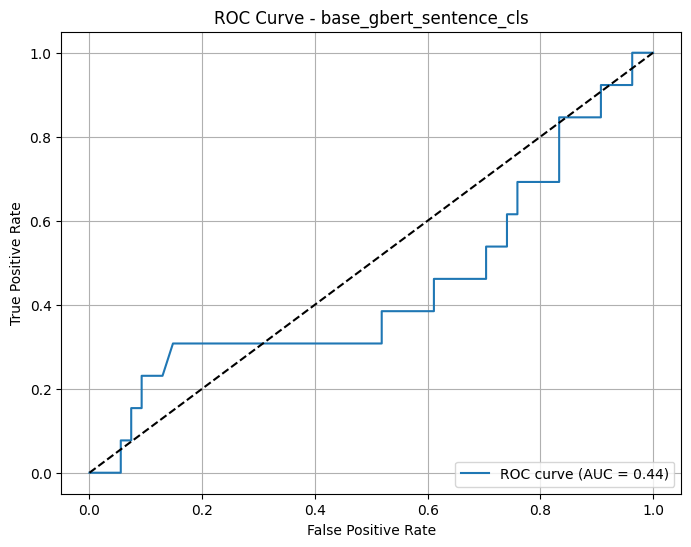

Optimaler Threshold für Cosine Similarity (%): 80.33


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,matched_catalog_id_base_gbert_sentence_cls,match_valid_base_gbert_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,-99,False
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,-99,False
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,-99,False
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,-99,False
64,25,§ 18,(3),für alle rechtsbeziehungen zwischen dem bestel...,"[0.25222683, -0.57086813, 0.20631789, -0.79424...",71,75.500000,Dieser Vertrag unterliegt dem Recht der Bundes...,Ist die anwendbare Rechtsordnung eindeutig ver...,Sonstige_wichtige_Klauseln,-99,False
65,26,16.,16.2,die außerordentliche kündigung wegen oder im z...,"[0.47250015, -0.0798389, 0.28309965, -1.937607...",55,62.880001,Der Kunde kann während der Projektdauer Änderu...,"Kann der Kunde zumutbare Änderungen verlangen,...",Änderungsmanagement,-99,False


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


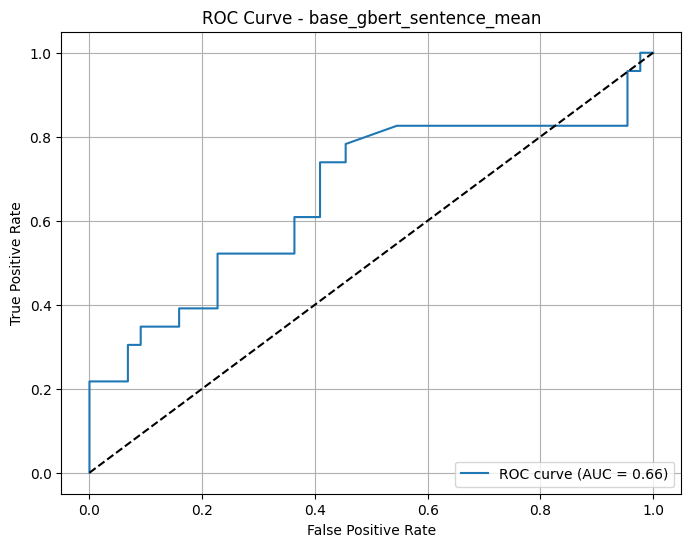

Optimaler Threshold für Cosine Similarity (%): 72.27


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,matched_catalog_id_base_gbert_sentence_cls,match_valid_base_gbert_sentence_cls,section_em_base_gbert_sentence_mean,matched_example_index_base_gbert_sentence_mean,similarity_percent_base_gbert_sentence_mean,matched_example_text_base_gbert_sentence_mean,matched_example_topic_base_gbert_sentence_mean,matched_paragraph_base_gbert_sentence_mean,matched_catalog_id_base_gbert_sentence_mean,match_valid_base_gbert_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,-99,False,"[-0.6960519, -0.28822985, 0.079094365, 0.50897...",26,67.730003,Mit der Abnahme der Gesamtleistung durch den K...,Werden die Folgen der Abnahme beschrieben (z.B...,Abnahmeprozesse,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),-99,False,"[0.049962074, -0.6499363, -0.23545866, 0.02870...",42,75.889999,Der Anbieter führt die vereinbarten Leistungen...,Sind die Pflichten des Anbieters und der Leist...,Rechte_und_Pflichten_der_Vertragsparteien,43,True
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,-99,False,"[-0.21976957, -0.2577378, -0.17936042, 0.35116...",18,75.300003,Erkennt eine Partei dass vereinbarte Termine n...,Gibt es vertragliche Regelungen für den Fall v...,Projektzeitplan_und_Meilensteine,19,True
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,-99,False,"[-0.25062132, 0.31500563, -0.113551736, 0.2213...",35,73.980003,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,36,True
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,-99,False,"[-0.07810443, -0.009561116, -0.10843899, 0.093...",57,70.029999,Auf Wunsch des Kunden unterstützt der Anbieter...,Unterstützt der Anbieter den Kunden beim Wechs...,Exit-Strategien_und_Datenportabilität,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,-99,False,"[0.47642618, 0.24663347, -0.075713634, 0.26218...",55,78.220001,Der Kunde kann während der Projektdauer Änderu...,"Kann der Kunde zumutbare Änderungen verlangen,...",Änderungsmanagement,56,True
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,-99,False,"[-0.6313862, 0.14326891, 0.24726342, -0.787895...",47,6

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


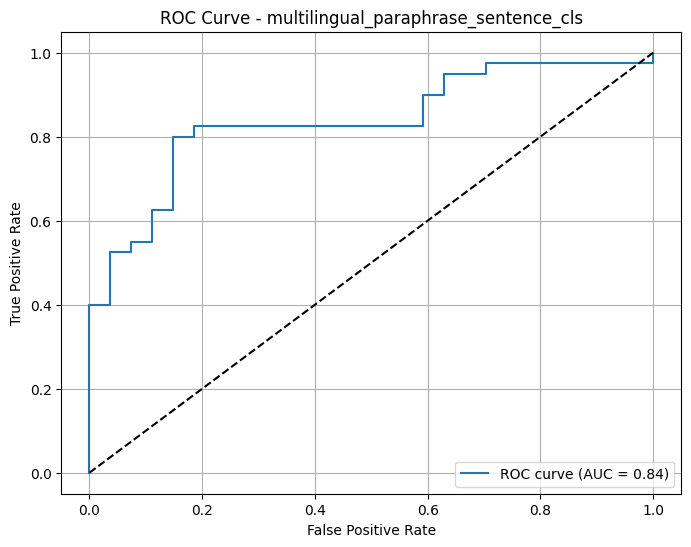

Optimaler Threshold für Cosine Similarity (%): 80.29


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_base_gbert_sentence_mean,match_valid_base_gbert_sentence_mean,section_em_multilingual_paraphrase_sentence_cls,matched_example_index_multilingual_paraphrase_sentence_cls,similarity_percent_multilingual_paraphrase_sentence_cls,matched_example_text_multilingual_paraphrase_sentence_cls,matched_example_topic_multilingual_paraphrase_sentence_cls,matched_paragraph_multilingual_paraphrase_sentence_cls,matched_catalog_id_multilingual_paraphrase_sentence_cls,match_valid_multilingual_paraphrase_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[0.0056744404, 0.18965931, 0.024314873, 0.1840...",69,79.169998,Endet der Vertrag vor Ablauf eines bereits im ...,"Ist geregelt, was mit vorausbezahlten Gebühren...",Vertragslaufzeit_und_Kündigung,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,43,True,"[0.16405895, -0.16609332, -0.06938068, -0.1943...",42,86.169998,Der Anbieter führt die vereinbarten Leistungen...,Sind die Pflichten des Anbieters und der Leist...,Rechte_und_Pflichten_der_Vertragsparteien,43,True
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,19,True,"[0.21067248, 0.13885413, -0.1595023, -0.263073...",47,89.459999,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,36,True,"[0.22590351, 0.035135582, -0.45249456, -0.2124...",35,89.750000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,36,True
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[0.35495007, -0.34120286, 0.08452363, -0.24378...",28,73.489998,Supportfälle werden wie folgt priorisiert Krit...,Sind Reaktions- und Lösungszeiten für Supportf...,Service-Level-Agreements_(SLAs),-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,56,True,"[0.18087436, 0.10366559, -0.07755377, 0.029214...",64,82.139999,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,65,True
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


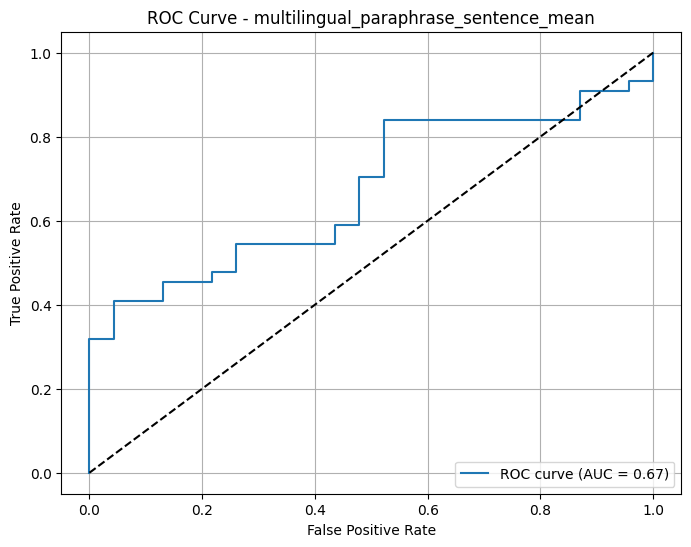

Optimaler Threshold für Cosine Similarity (%): 77.27


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_multilingual_paraphrase_sentence_cls,match_valid_multilingual_paraphrase_sentence_cls,section_em_multilingual_paraphrase_sentence_mean,matched_example_index_multilingual_paraphrase_sentence_mean,similarity_percent_multilingual_paraphrase_sentence_mean,matched_example_text_multilingual_paraphrase_sentence_mean,matched_example_topic_multilingual_paraphrase_sentence_mean,matched_paragraph_multilingual_paraphrase_sentence_mean,matched_catalog_id_multilingual_paraphrase_sentence_mean,match_valid_multilingual_paraphrase_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-0.23610508, 0.20052604, -0.12860887, 0.13919...",69,66.110001,Endet der Vertrag vor Ablauf eines bereits im ...,"Ist geregelt, was mit vorausbezahlten Gebühren...",Vertragslaufzeit_und_Kündigung,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,43,True,"[-0.1300929, -0.09653837, -0.16809261, -0.1503...",42,74.849998,Der Anbieter führt die vereinbarten Leistungen...,Sind die Pflichten des Anbieters und der Leist...,Rechte_und_Pflichten_der_Vertragsparteien,-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,48,True,"[-0.04502529, 0.11500616, -0.23708475, -0.1637...",47,88.199997,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,36,True,"[0.047989476, 0.01426668, -0.4084031, -0.17058...",35,84.669998,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,36,True
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[0.2740171, 0.02801082, 0.15851402, 0.06545845...",28,32.169998,Supportfälle werden wie folgt priorisiert Krit...,Sind Reaktions- und Lösungszeiten für Supportf...,Service-Level-Agreements_(SLAs),-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,65,True,"[0.009979235, 0.16148809, -0.18574135, 0.01869...",64,79.669998,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,65,True
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Pa

Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


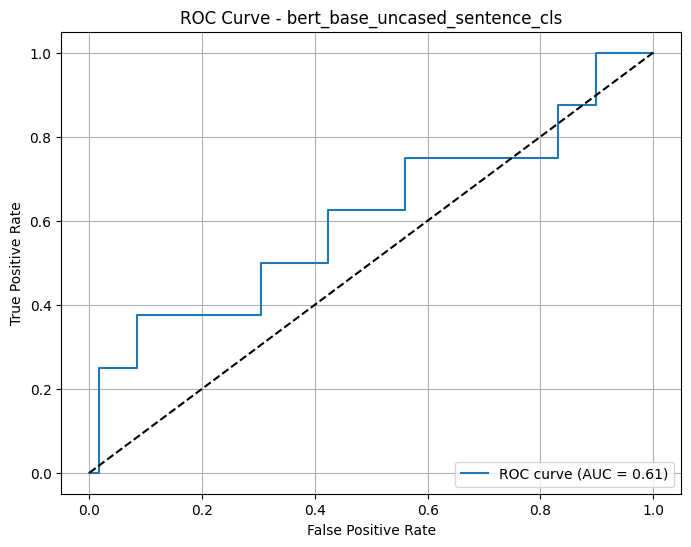

Optimaler Threshold für Cosine Similarity (%): 97.90


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_multilingual_paraphrase_sentence_mean,match_valid_multilingual_paraphrase_sentence_mean,section_em_bert_base_uncased_sentence_cls,matched_example_index_bert_base_uncased_sentence_cls,similarity_percent_bert_base_uncased_sentence_cls,matched_example_text_bert_base_uncased_sentence_cls,matched_example_topic_bert_base_uncased_sentence_cls,matched_paragraph_bert_base_uncased_sentence_cls,matched_catalog_id_bert_base_uncased_sentence_cls,match_valid_bert_base_uncased_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-0.48365188, 0.37736478, -0.17439969, -0.3041...",60,97.269997,Die Haftung des Anbieters aus und im Zusammenh...,Ist die Haftung der Höhe nach begrenzt (z.B. a...,Haftung_und_Gewährleistung,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,-99,False,"[-0.754841, 0.5274122, -0.23717138, -0.5054350...",73,96.690002,Dieser Vertrag wird in deutscher und englische...,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",Sonstige_wichtige_Klauseln,-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,48,True,"[-0.49534935, 0.5905716, -0.09981969, -0.38686...",37,97.250000,Der Anbieter wird den Kunden unverzüglich schr...,"Verpflichtet sich der Anbieter, Sicherheitsvor...",Datenschutz_und_Informationssicherheit,-99,False
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,36,True,"[-0.4966326, 0.7556418, -0.075088605, -0.28509...",75,97.300003,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,-99,False
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[-0.318211, 0.39903048, 0.10681064, 0.17356071...",10,92.010002,Das eingeführte System muss 100 gleichzeitige ...,Werden qualitative Anforderungen oder Leistung...,Leistungsbeschreibung_und_Deliverables,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,65,True,"[-0.77850753, 0.6943653, 0.19770537, -0.212119...",24,98.089996,Verweigert der Kunde die Abnahme wegen erhebli...,"Ist geregelt, was passiert, wenn bei der Abnah...",Abnahmeprozesse,25,True
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer

Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


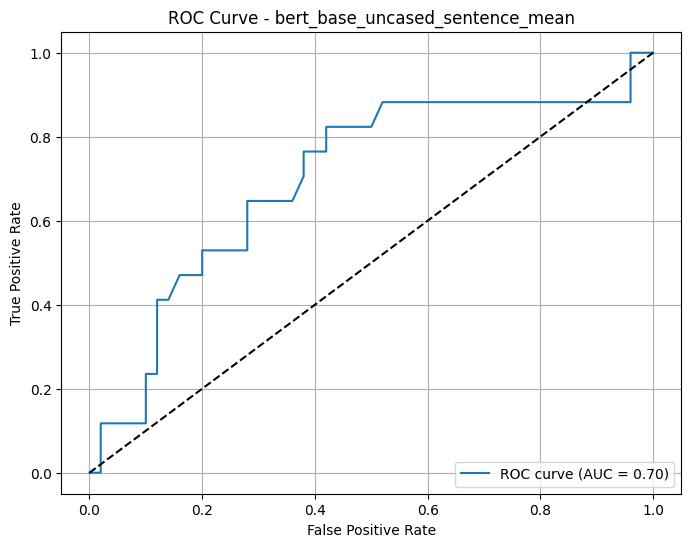

Optimaler Threshold für Cosine Similarity (%): 96.36


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_bert_base_uncased_sentence_cls,match_valid_bert_base_uncased_sentence_cls,section_em_bert_base_uncased_sentence_mean,matched_example_index_bert_base_uncased_sentence_mean,similarity_percent_bert_base_uncased_sentence_mean,matched_example_text_bert_base_uncased_sentence_mean,matched_example_topic_bert_base_uncased_sentence_mean,matched_paragraph_bert_base_uncased_sentence_mean,matched_catalog_id_bert_base_uncased_sentence_mean,match_valid_bert_base_uncased_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-0.6638517, 0.04017214, 0.15503876, -0.148629...",54,96.029999,Für jede vereinbarte Leistungsänderung wird ei...,"Wird gefordert, dass bei jeder genehmigten Änd...",Änderungsmanagement,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,-99,False,"[-0.7353345, 0.024043547, 0.0861195, -0.082865...",6,95.809998,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-0.60054827, 0.1555062, 0.30097985, 0.0145977...",47,98.300003,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,-99,False,"[-0.6275823, 0.17365845, 0.24400558, -0.055495...",75,98.360001,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,76,True
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[-0.4858902, 0.104457095, 0.30673277, 0.016255...",47,95.559998,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,25,True,"[-0.7410642, 0.1278668, 0.28930494, -0.0547286...",55,98.230003,Der Kunde kann während der Projektdauer Änderu...,"Kann der Kunde zumutbare Änderungen verlangen,...",Änderungsmanagement,56,True
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt be

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]


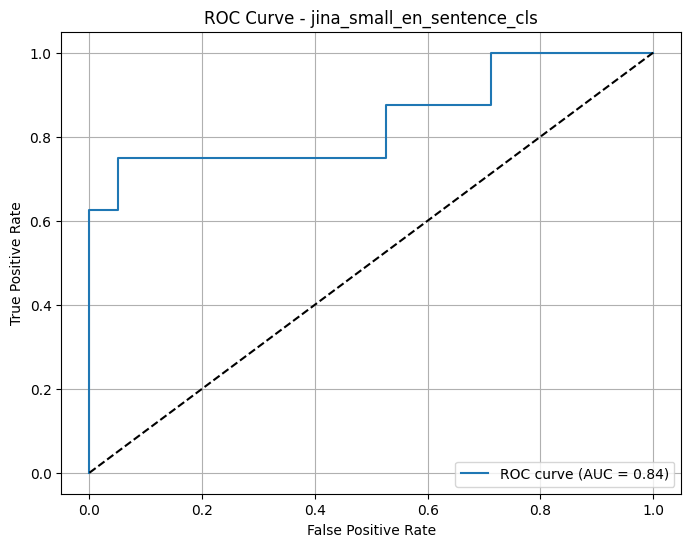

Optimaler Threshold für Cosine Similarity (%): 93.62


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_bert_base_uncased_sentence_mean,match_valid_bert_base_uncased_sentence_mean,section_em_jina_small_en_sentence_cls,matched_example_index_jina_small_en_sentence_cls,similarity_percent_jina_small_en_sentence_cls,matched_example_text_jina_small_en_sentence_cls,matched_example_topic_jina_small_en_sentence_cls,matched_paragraph_jina_small_en_sentence_cls,matched_catalog_id_jina_small_en_sentence_cls,match_valid_jina_small_en_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-1.1962878, -2.073433, -0.16790812, 0.5711254...",2,90.730003,Die Vergütung ist in drei Raten zahlbar 30 bei...,Ist ein Zahlungsplan mit konkreten Fälligkeite...,Projektkosten_und_Zahlungsmodalitäten,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,-99,False,"[-0.40474135, -2.0627074, -0.9325801, 0.281841...",1,90.379997,Der Kunde zahlt eine monatliche Pauschale von ...,Ist das Vergütungsmodell eindeutig festgelegt ...,Projektkosten_und_Zahlungsmodalitäten,-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,48,True,"[-1.374341, -0.83957595, -0.84339523, 0.176856...",64,88.339996,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,-99,False
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,76,True,"[-1.3108326, -0.99067146, -0.8542628, 0.835711...",64,86.519997,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,-99,False
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[-1.0184335, -1.6994938, -0.9532909, -0.179213...",75,83.410004,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,56,True,"[-1.0695599, -0.9084098, -1.178159, 0.36792383...",46,86.120003,Individuelle Entwicklungen die der Anbieter im...,"Wird geregelt, wem neu entstehende Arbeitserge...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtig

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


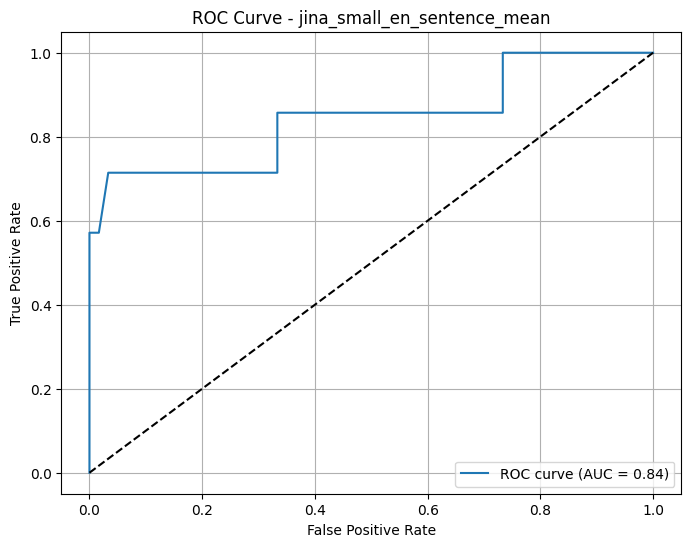

Optimaler Threshold für Cosine Similarity (%): 92.27


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_jina_small_en_sentence_cls,match_valid_jina_small_en_sentence_cls,section_em_jina_small_en_sentence_mean,matched_example_index_jina_small_en_sentence_mean,similarity_percent_jina_small_en_sentence_mean,matched_example_text_jina_small_en_sentence_mean,matched_example_topic_jina_small_en_sentence_mean,matched_paragraph_jina_small_en_sentence_mean,matched_catalog_id_jina_small_en_sentence_mean,match_valid_jina_small_en_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-0.63051754, -0.7826597, -0.6688989, 1.162020...",2,88.540001,Die Vergütung ist in drei Raten zahlbar 30 bei...,Ist ein Zahlungsplan mit konkreten Fälligkeite...,Projektkosten_und_Zahlungsmodalitäten,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,-99,False,"[-0.8157011, -0.57902557, -1.6280628, 0.787247...",73,88.610001,Dieser Vertrag wird in deutscher und englische...,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",Sonstige_wichtige_Klauseln,-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-1.7430557, -0.5208562, -1.3838414, 0.5018714...",23,89.599998,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,-99,False
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,-99,False,"[-1.4864392, -0.81560826, -1.0541776, 0.736706...",75,90.589996,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,-99,False
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[-0.97115195, -0.1843377, -0.86178803, 0.67692...",75,83.779999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-1.3897977, -0.6789018, -0.96083206, 0.499530...",75,89.510002,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,-99,False
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,...,-99,False,"[-

Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


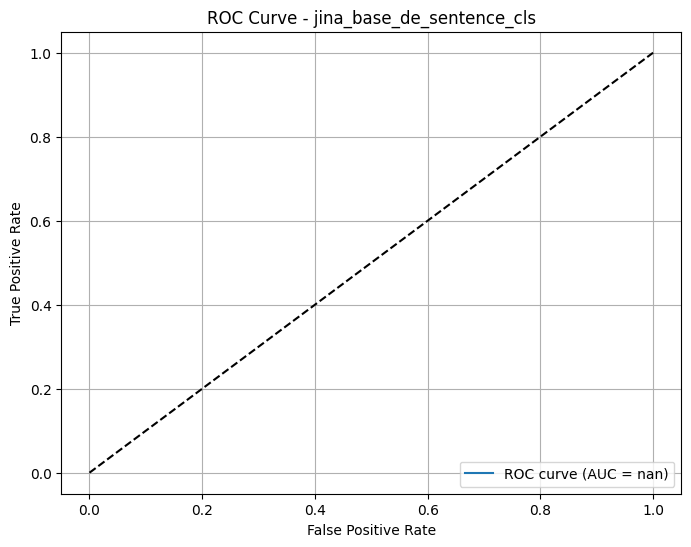

Optimaler Threshold für Cosine Similarity (%): inf


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_jina_small_en_sentence_mean,match_valid_jina_small_en_sentence_mean,section_em_jina_base_de_sentence_cls,matched_example_index_jina_base_de_sentence_cls,similarity_percent_jina_base_de_sentence_cls,matched_example_text_jina_base_de_sentence_cls,matched_example_topic_jina_base_de_sentence_cls,matched_paragraph_jina_base_de_sentence_cls,matched_catalog_id_jina_base_de_sentence_cls,match_valid_jina_base_de_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-0.68965554, -1.4416232, 0.45469505, 1.349861...",34,39.730000,Der Anbieter speichert und verarbeitet Kundend...,"Ist geregelt, wo die Kundendaten gespeichert/v...",Datenschutz_und_Informationssicherheit,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,-99,False,"[0.84279054, -0.70768255, -0.017011454, 1.8785...",33,51.090000,Die Parteien schließen vor Leistungsbeginn ein...,Wird – falls der Anbieter personenbezogene Dat...,Datenschutz_und_Informationssicherheit,-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-1.1522199, 1.924525, 0.08279678, 1.6293287, ...",19,42.189999,Die Projektparteien führen mindestens alle 14 ...,Sind regelmäßige Abstimmungs- und Statusmeetin...,Projektzeitplan_und_Meilensteine,-99,False
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,-99,False,"[0.55832404, -0.84836406, 1.1156694, 0.2546307...",37,37.279999,Der Anbieter wird den Kunden unverzüglich schr...,"Verpflichtet sich der Anbieter, Sicherheitsvor...",Datenschutz_und_Informationssicherheit,-99,False
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[-0.6378031, 0.68256044, -0.4670406, 1.0530293...",31,40.689999,Der Anbieter leistet technischen Support für d...,Sind die Servicezeiten (Support-Verfügbarkeit)...,Service-Level-Agreements_(SLAs),-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[0.29286194, -0.1600021, 0.05226382, -0.492255...",59,38.970001,Der Anbieter wird 60 Tage nach Vertragsende sä...,"Verpflichtet sich der Anbieter, Kundendaten na...",Exit-Strategien_und_Datenportabilität,-99,False
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",S

Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


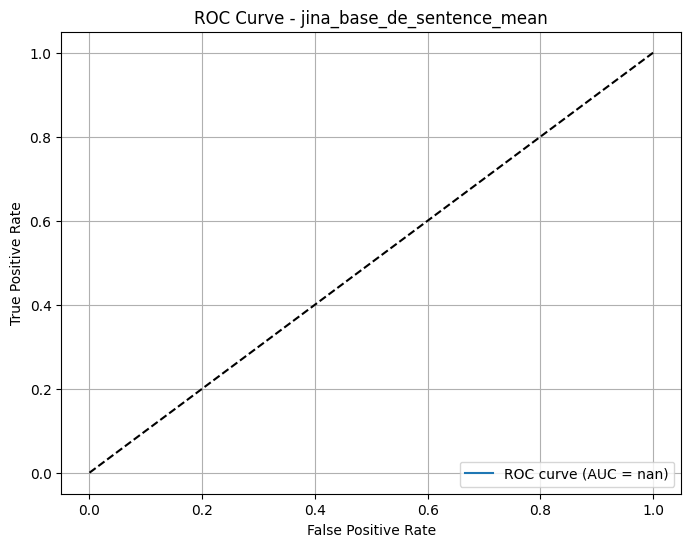

Optimaler Threshold für Cosine Similarity (%): inf


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_jina_base_de_sentence_cls,match_valid_jina_base_de_sentence_cls,section_em_jina_base_de_sentence_mean,matched_example_index_jina_base_de_sentence_mean,similarity_percent_jina_base_de_sentence_mean,matched_example_text_jina_base_de_sentence_mean,matched_example_topic_jina_base_de_sentence_mean,matched_paragraph_jina_base_de_sentence_mean,matched_catalog_id_jina_base_de_sentence_mean,match_valid_jina_base_de_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[0.024617998, -0.8025899, 0.4099316, 1.2097566...",34,44.830002,Der Anbieter speichert und verarbeitet Kundend...,"Ist geregelt, wo die Kundendaten gespeichert/v...",Datenschutz_und_Informationssicherheit,-99,False
1,2,§ 8,(1),der kunde wird den anbieter bei der erbringung...,"[0.10046706, -0.7135258, -0.30797762, -0.19059...",29,79.860001,Regelmäßige Wartungen finden einmal pro Monat ...,Sind geplante Wartungsfenster und Updateszeite...,Service-Level-Agreements_(SLAs),...,-99,False,"[0.8647885, -0.5129231, -0.217151, 1.6726452, ...",33,50.240002,Die Parteien schließen vor Leistungsbeginn ein...,Wird – falls der Anbieter personenbezogene Dat...,Datenschutz_und_Informationssicherheit,-99,False
2,2,§ 11,(3),der kunde verpflichtet sich diesem zusammen ha...,"[0.07079946, -0.91930145, -0.5190848, -0.66178...",48,77.110001,Der Anbieter ist berechtigt zur Erfüllung sein...,Darf der Anbieter zur Leistungserbringung Subu...,Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-1.0452284, 0.422658, 0.1897371, 1.2456126, -...",19,50.080002,Die Projektparteien führen mindestens alle 14 ...,Sind regelmäßige Abstimmungs- und Statusmeetin...,Projektzeitplan_und_Meilensteine,-99,False
3,2,§ 13,(1),die parteien sind verpflichtet alle ihnen im z...,"[0.24007232, -0.09389134, -0.09494708, -0.8681...",35,73.570000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,...,-99,False,"[0.66309965, -0.6741007, 1.4345851, 0.7400012,...",38,38.910000,Sämtliche Daten die der Kunde im Rahmen der Nu...,"Bleibt klargestellt, dass alle vom Kunden stam...",Datenschutz_und_Informationssicherheit,-99,False
4,3,1.,1.9,„reaktionszeit“ bezeichnet die zeit stunden od...,"[0.16465195, -0.6930231, 0.97895896, -1.039280...",23,62.639999,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,...,-99,False,"[-0.7253185, 0.7570847, -0.56993175, 1.2258384...",24,45.599998,Verweigert der Kunde die Abnahme wegen erhebli...,"Ist geregelt, was passiert, wenn bei der Abnah...",Abnahmeprozesse,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),der besteller kann ersatz für die zum zweck de...,"[0.87762314, -0.71939224, 0.27685755, -0.06882...",7,80.209999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[0.5651677, -0.80290484, -0.010791718, -0.1245...",59,45.950001,Der Anbieter wird 60 Tage nach Vertragsende sä...,"Verpflichtet sich der Anbieter, Kundendaten na...",Exit-Strategien_und_Datenportabilität,-99,False
63,25,§ 13,(3),sofern wir fahrlässig eine vertragswesentliche...,"[0.11125465, -0.516883, 0.23583777, -1.3440251...",75,67.889999,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wi

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
df_to_match = df_labeled[["contract","paragraph","section","clean_section_content"]]
df_true_match = df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
df_true_match.rename(columns={"catalog_id": "true_catalog_id"},inplace= True)
cols = ["contract","paragraph","section","clean_section_content"]



for model_name in models_dict:
    model_selected = models_dict[model_name]
    df_to_match = embed_text_column(df_to_match, text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}" )
    cat = embed_text_column(catalogue, text_column = "example", model = model_selected, target_column = "emb")
    cols.append(f"section_em_{model_name}")
    df_to_match  = df_to_match[cols]
    X = np.vstack(df_to_match[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
    Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

    # Cosine Similarity: alle Kombinationen
    similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
    similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Ergebnisse anhängen
    df_to_match[f"matched_example_index_{model_name}"] = best_match_idx
    df_to_match[f"similarity_percent_{model_name}"] = best_match_score
    df_to_match[f"matched_example_text_{model_name}"] = cat.loc[best_match_idx, "example"].values
    df_to_match[f"matched_example_topic_{model_name}"] = cat.loc[best_match_idx, "section_topic"].values
    df_to_match[f"matched_paragraph_{model_name}"] = cat.loc[best_match_idx, "paragraph_topic"].values
    df_to_match[f"matched_catalog_id_{model_name}"] = cat.loc[best_match_idx, "catalog_id"].values
    

    y_true = (df_true_match["true_catalog_id"].values == df_to_match[f"matched_catalog_id_{model_name}"].values).astype(int)
    y_scores = df_to_match[f"similarity_percent_{model_name}"].values / 100  # zurück zu 0–1

    # ROC-Kurve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    # Optimaler Threshold = max(tpr - fpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimaler Threshold für Cosine Similarity (%): {optimal_threshold * 100:.2f}")
    # Neue Spalte: Match nur wenn Score >= Threshold
    df_to_match[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
    df_to_match.loc[~df_to_match[f"match_valid_{model_name}"], f"matched_catalog_id_{model_name}"] = -99
    cols = list(df_to_match.columns)
    display(df_to_match)

    










In [36]:
df_matched = df_to_match
from sklearn.metrics import accuracy_score, f1_score, classification_report

results = []

for model_name in models_dict:
    print(f"### {model_name} ###")
    df_matched_ids = df_matched[["contract","paragraph","section","clean_section_content",f"matched_catalog_id_{model_name}"]]
    print("Accuracy:", accuracy_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))
    print("F1 (macro):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'))
    print("F1 (weighted):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted'))
    print("\nReport:\n", classification_report(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))

    print(f"### {model_name} ###")

    results.append({
            "model": model_name,
            "Accuracy": accuracy_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]),
            "F1 (macro)": f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'),
            "F1 (weighted)": f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted')
        })


### base_gbert_sentence_cls ###
Accuracy: 0.05970149253731343
F1 (macro): 0.06453634085213034
F1 (weighted): 0.0828002842928216

Report:
               precision    recall  f1-score   support

         -99       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00        

/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

[-99   8  32  51  67   3   5   7  20  27  54  75]


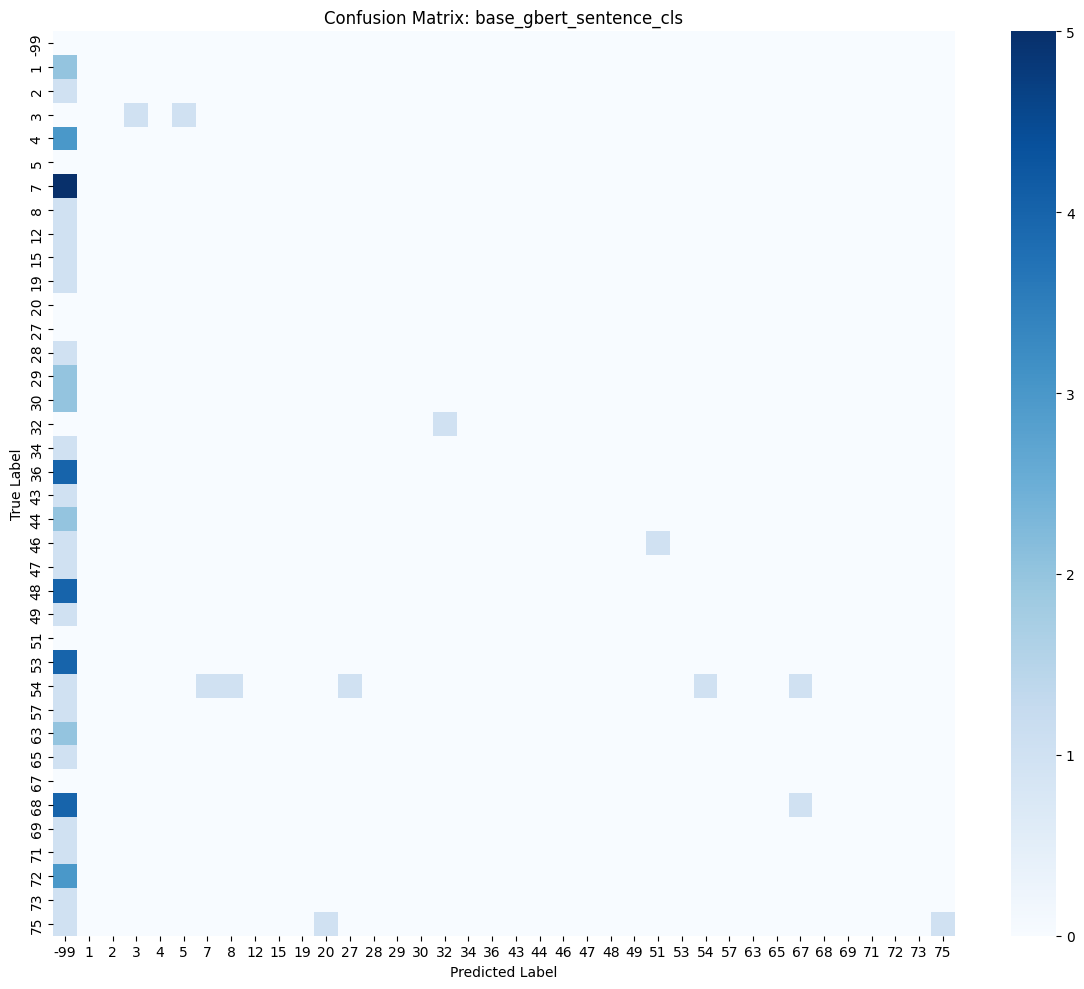

[-99  43  19  36  48  69  34  63  56  47  46  75  58   6  40   1  27  45
  44   9   8  54  72]


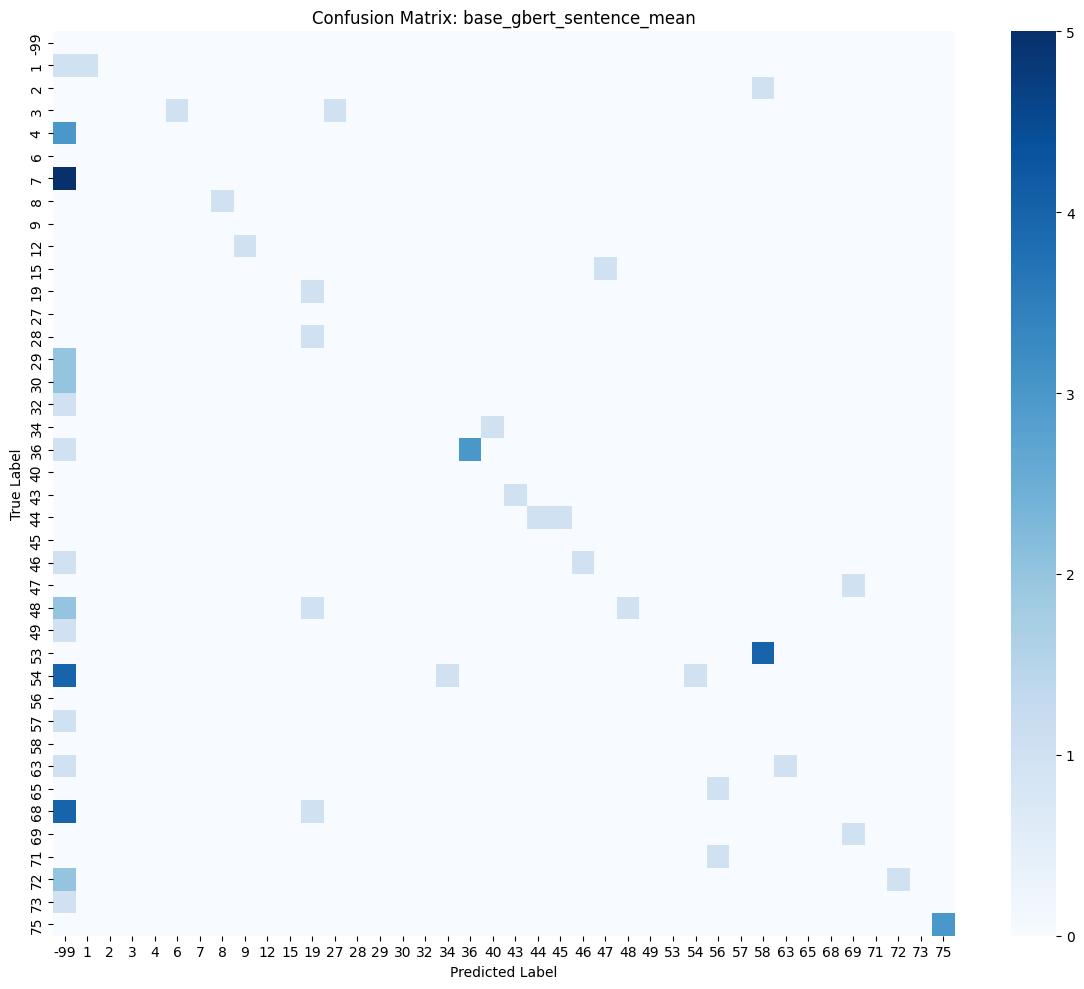

[-99  43  48  36  65  54  63  19  71  49  46  75  72  53  29  30  44   8
  52]


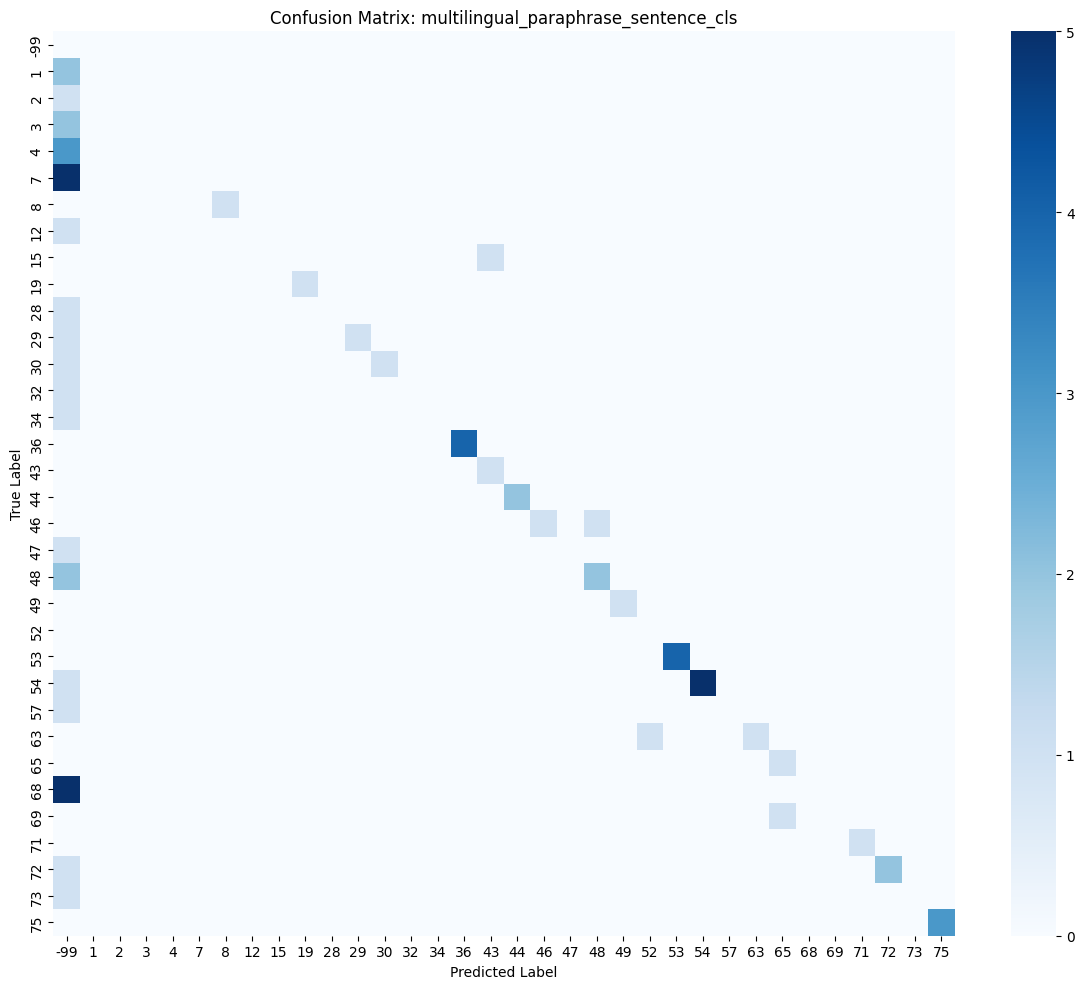

[-99  48  36  54  19  75  72  34  44  65  73]


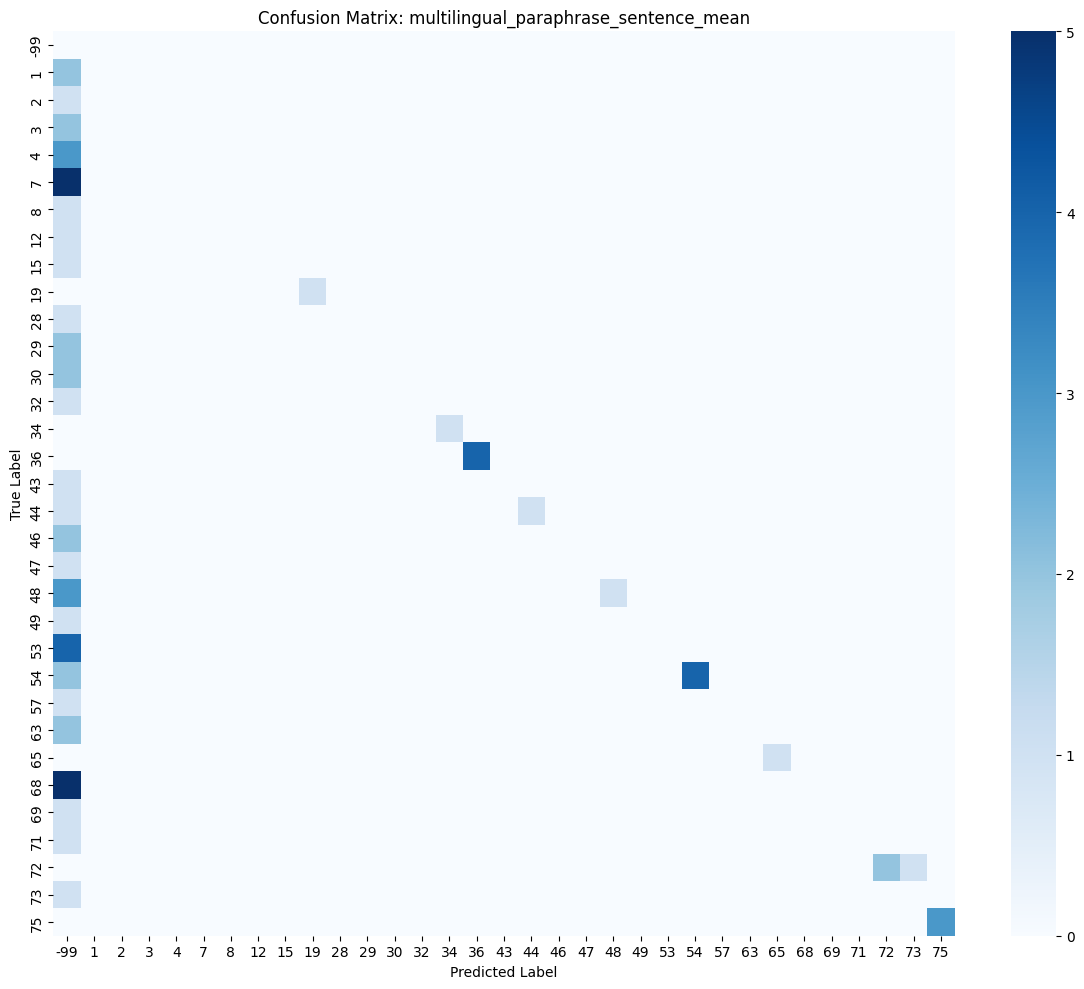

[-99  63  71  51  42  75  25]


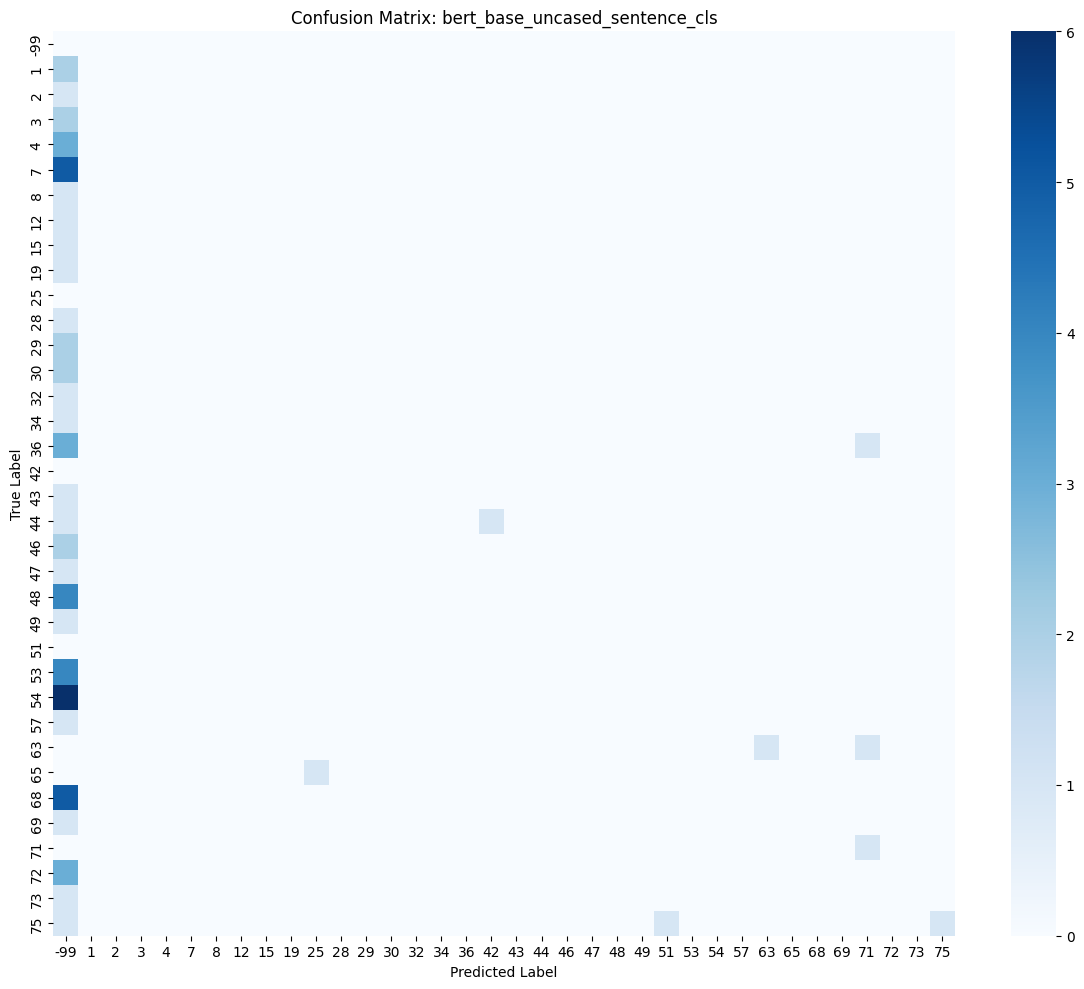

[-99  48  76  36  55  51  70  71  43  68  75  24  40  72  14  31  62  44
   8  53  56]


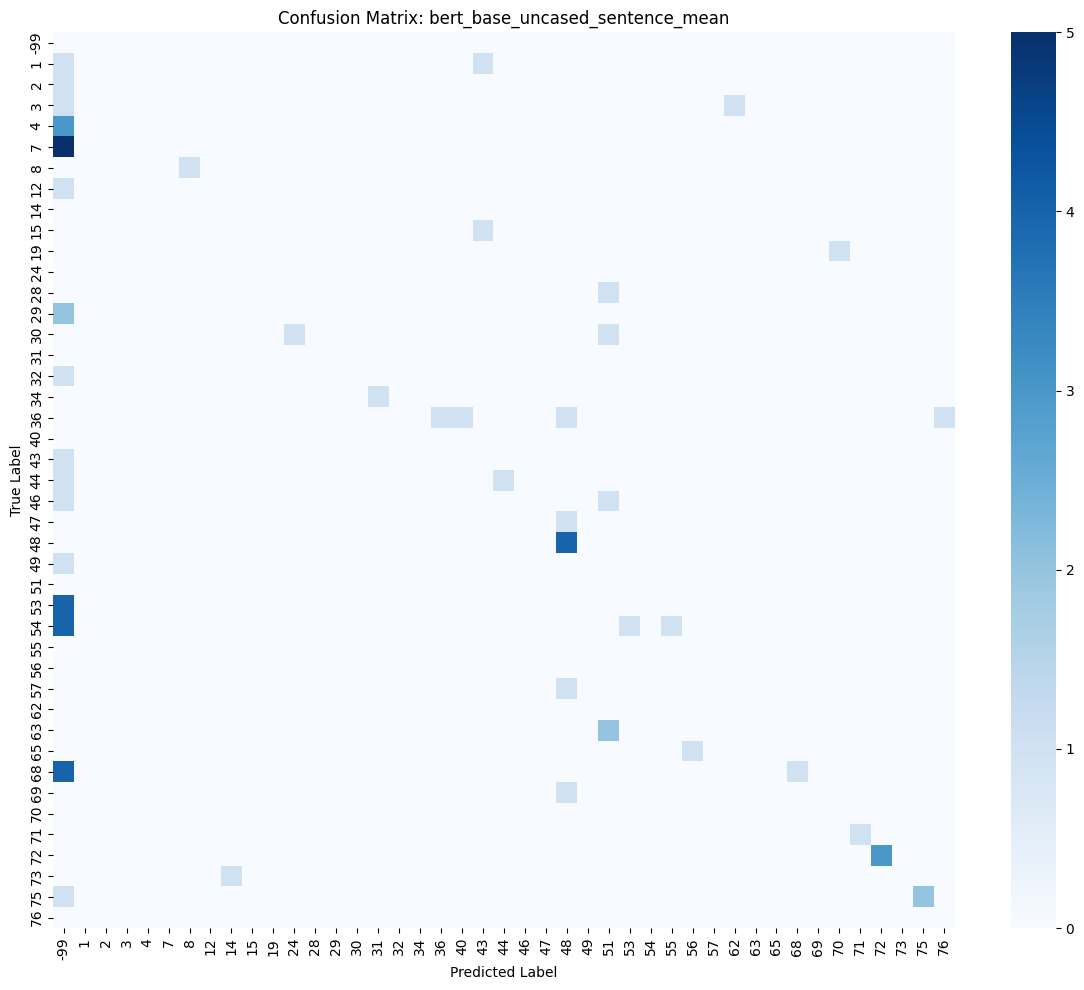

[-99  54  75  72  73  61   7]


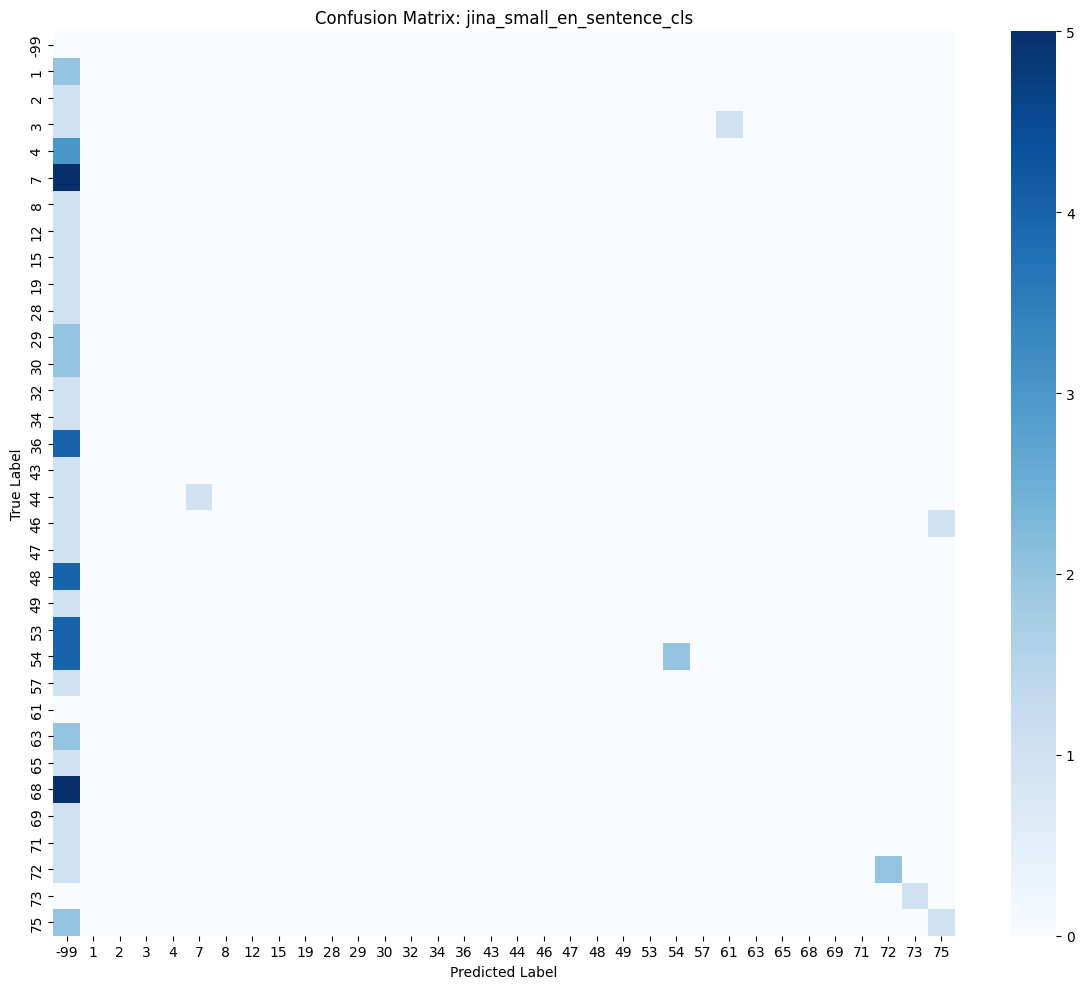

[-99  54  63   8  71  72]


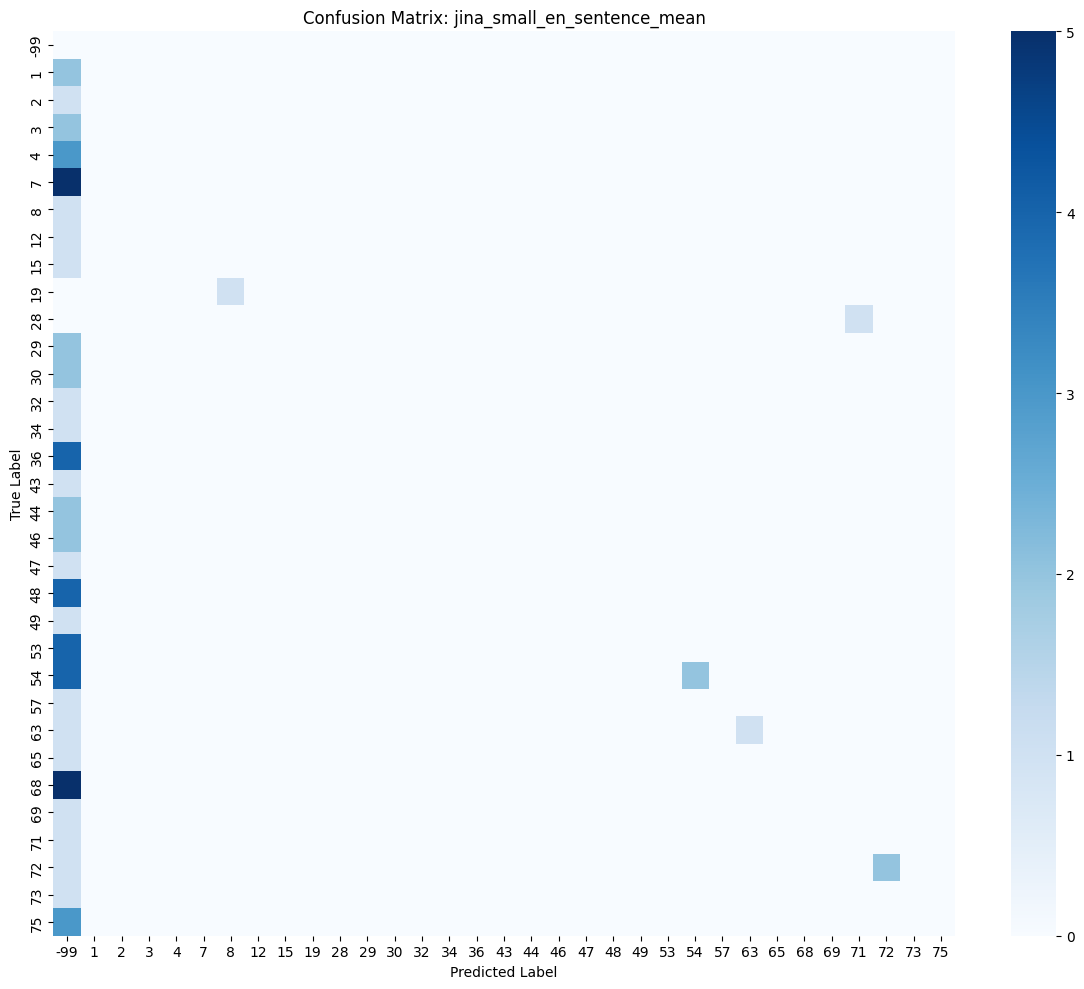

[-99]


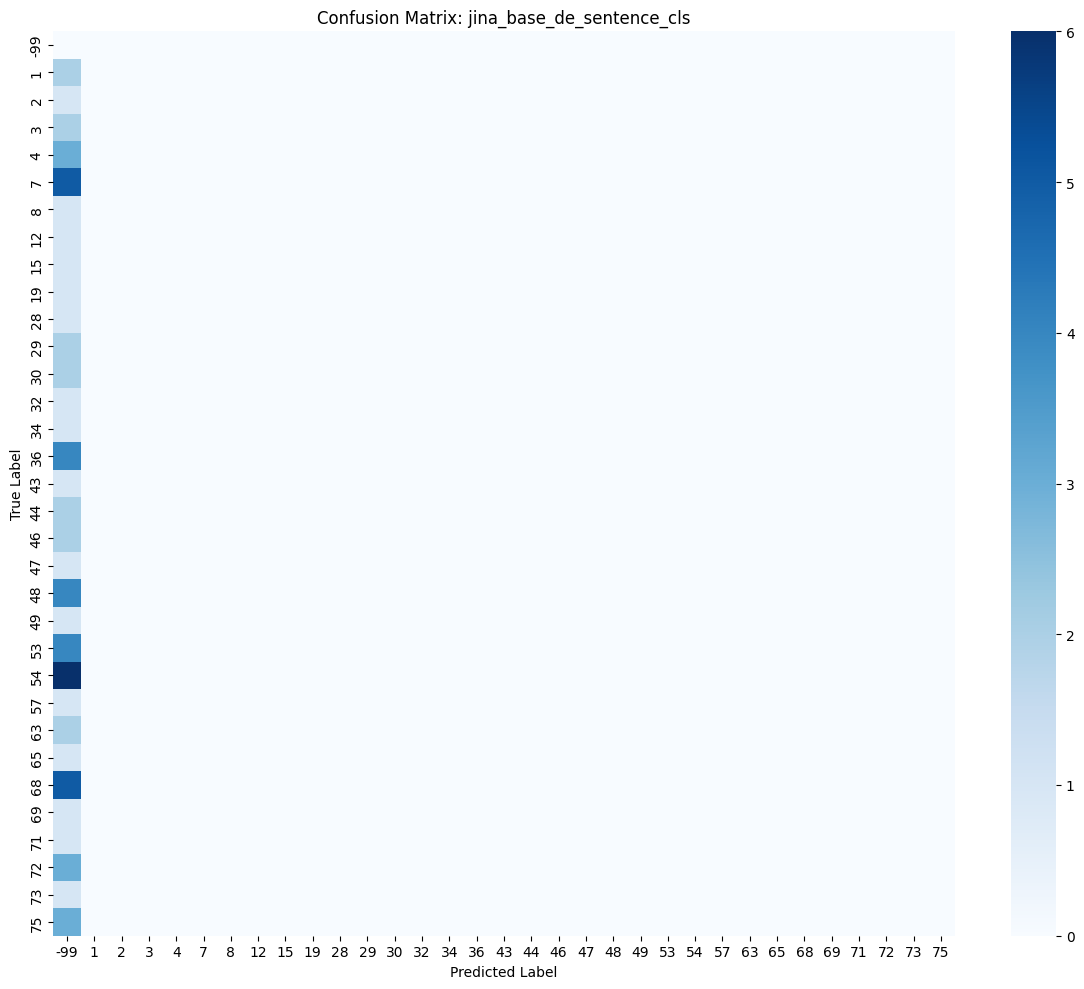

[-99]


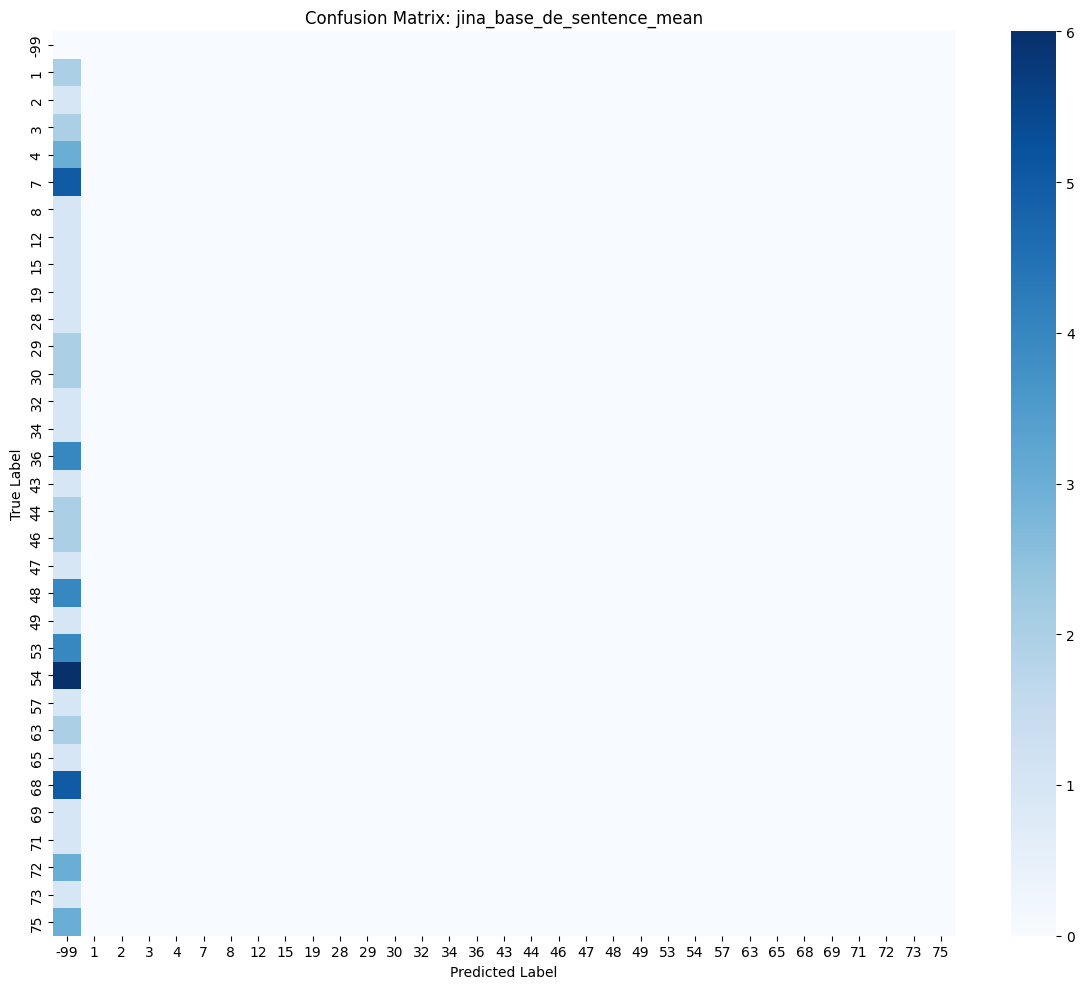

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
for model_name in models_dict:
    # Für bessere Lesbarkeit als np.array
    df_matched_ids = df_matched[["contract","paragraph","section","clean_section_content",f"matched_catalog_id_{model_name}"]]
    y_true = df_true_match["true_catalog_id"]
    y_pred = df_matched_ids[f"matched_catalog_id_{model_name}"]
    print(df_matched_ids[f"matched_catalog_id_{model_name}"].unique())
    # Confusion Matrix berechnen
    all_labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", 
                xticklabels=all_labels, 
                yticklabels=all_labels)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [41]:

results_df = pd.DataFrame(results).sort_values("F1 (weighted)", ascending=False)
display(results_df)


,model,Accuracy,F1 (macro),F1 (weighted)
2,multilingual_paraphrase_sentence_cls,0.477612,0.420015,0.504581
3,multilingual_paraphrase_sentence_mean,0.268657,0.232323,0.300498
1,base_gbert_sentence_mean,0.253731,0.219405,0.293177
5,bert_base_uncased_sentence_mean,0.208955,0.136434,0.218905
6,jina_small_en_sentence_cls,0.089552,0.079412,0.113433
7,jina_small_en_sentence_mean,0.074627,0.059596,0.100498
0,base_gbert_sentence_cls,0.059701,0.064536,0.082800
4,bert_base_uncased_sentence_cls,0.044776,0.046296,0.049751
8,jina_base_de_sentence_cls,0.000000,0.000000,0.000000
9,jina_base_de_sentence_mean,0.000000,0.000000,0.000000
